In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow_probability as tfp

2023-05-22 05:57:51.491719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 05:57:51.552917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-22 05:57:51.553945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 05:57:52.508210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import keras.backend as K
from keras_vggface import VGGFace
from keras_vggface.utils import preprocess_input
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Read Data

In [3]:
df = pd.read_csv("data.csv", index_col = 0)

In [4]:
df_train = df[df['is_training'] == 1].copy()
df_test = df[df['is_training'] == 0].copy()

In [5]:
df_train.shape, df_test.shape

((3368, 4), (838, 4))

In [6]:
folder_path = './Images'

X_train = []
y_train = []

for index, row in df_train.iterrows():
    image_filename = row['name']
    image_path = os.path.join(folder_path, image_filename)
    #check if image file exists
    if not os.path.exists(image_path):
        continue
    #load image
    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.astype(np.float32) / 255.0
    
    X_train.append(image)
    y_train.append(row['bmi'])

In [7]:
X_test = []
y_test = []

for index, row in df_test.iterrows():
    image_filename = row['name']
    image_path = os.path.join(folder_path, image_filename)
    #check if image file exists
    if not os.path.exists(image_path):
        continue
    #load image
    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.astype(np.float32) / 255.0
    
    X_test.append(image)
    y_test.append(row['bmi'])

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3126, 224, 224, 3), (752, 224, 224, 3), (3126,), (752,))

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3126, 752, 3126, 752)

In [11]:
# Create an ImageDataGenerator for augmentation
data_generator = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Image Preprocessing

In [12]:
X_train = data_generator.flow(X_train, batch_size=1)
X_test = data_generator.flow(X_test, batch_size=1)

In [13]:
X_train_new = []
X_test_new = []

In [14]:
for i in range(len(X_train)):
    batch = next(X_train)
    X_train_new.append(batch[0])
X_train_new = np.array(X_train_new)

In [15]:
for i in range(len(X_test)):
    batch = next(X_test)
    X_test_new.append(batch[0])
X_test_new = np.array(X_test_new)

In [16]:
X_train_new.shape,X_test_new.shape

((3126, 224, 224, 3), (752, 224, 224, 3))

# Fine-tune VGGFace

In [20]:
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [21]:
# Unfreeze the last few layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [22]:
# Add additional layers for BMI prediction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
bmi_output = Dense(1, activation='linear', name='bmi_output')(x)

In [23]:
model = Model(inputs=base_model.input, outputs=bmi_output)

In [24]:
from tensorflow.keras.metrics import MeanAbsoluteError
model.compile(optimizer=Adam(), loss='mse', metrics=[MeanAbsoluteError()])

# Train modified model on our dataset

In [25]:
model.fit(X_train_new, y_train, validation_split=0.25, epochs=20, batch_size=64, shuffle=True)

Epoch 1/20
37/37 [==============================] - 451s 12s/step - loss: 1333.2639 - mean_absolute_error: 29.1073 - val_loss: 165.4785 - val_mean_absolute_error: 10.1127
Epoch 2/20
37/37 [==============================] - 441s 12s/step - loss: 127.9123 - mean_absolute_error: 8.8182 - val_loss: 99.0405 - val_mean_absolute_error: 7.7856
Epoch 3/20
37/37 [==============================] - 441s 12s/step - loss: 95.3723 - mean_absolute_error: 7.6413 - val_loss: 92.9290 - val_mean_absolute_error: 7.7774
Epoch 4/20
37/37 [==============================] - 447s 12s/step - loss: 79.2128 - mean_absolute_error: 6.9604 - val_loss: 69.6670 - val_mean_absolute_error: 6.3933
Epoch 5/20
37/37 [==============================] - 448s 12s/step - loss: 71.7729 - mean_absolute_error: 6.6233 - val_loss: 66.6552 - val_mean_absolute_error: 6.5545
Epoch 6/20
37/37 [==============================] - 443s 12s/step - loss: 69.1432 - mean_absolute_error: 6.5393 - val_loss: 70.6374 - val_mean_absolute_error: 7.049

In [26]:
# save model
model.save('./project_model.h5')
print("Saved model")

Saved model


In [27]:
# Predict using the model built
from tensorflow.keras.models import load_model
model_loaded = load_model('project_model.h5')
print("Loaded model from disk")

Loaded model from disk


In [28]:
# Make predictions
predictions = model.predict(X_test_new)

24/24 [==============================] - 17s 685ms/step


In [29]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, predictions)
print("Test MAE:", test_mae)

Test MAE: 7.199764215149894


Image 1 Predicted BMI: [31.652782]


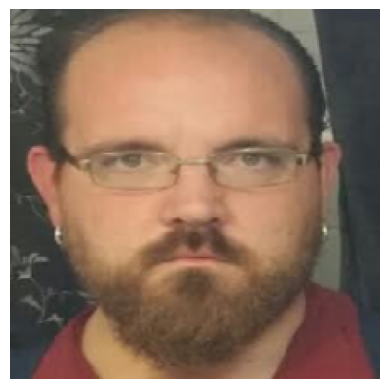

Image 2 Predicted BMI: [31.321114]


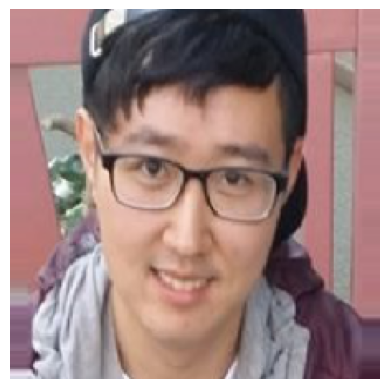

Image 3 Predicted BMI: [30.989786]


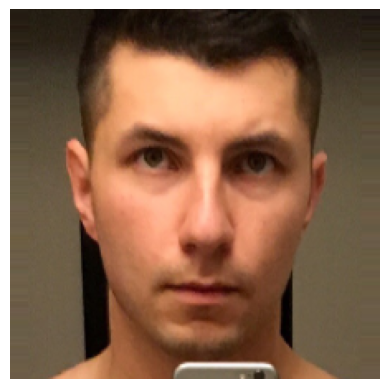

In [30]:
#display BMI with image
for i in range(3):
    print("Image", i+1, "Predicted BMI:", predictions[i])
    #display image
    plt.imshow(X_test_new[i])
    plt.axis('off')
    plt.show()